In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import chainer.functions as F
import chainer.links as L
import chainerrl
import chainer
from gym import spaces

from arm import Arm

In [41]:
env=Arm(4,[1.,1.,1.,1])

In [42]:
##Q関数の定義
class QFunction(chainer.Chain):

    def __init__(self,obs_size,n_actions,n_hidden_channels=50):
        super().__init__()
        with self.init_scope():
            self.l0=L.Linear(obs_size,n_hidden_channels)
            self.l1=L.Linear(n_hidden_channels,n_hidden_channels*2)
            self.l2=L.Linear(n_hidden_channels*2,n_hidden_channels*2)
            self.l3=L.Linear(n_hidden_channels*2,n_actions)

    def __call__(self,x,test=False):
        h=F.tanh(self.l0(x))
        h=F.tanh(self.l1(h))
        h=F.tanh(self.l2(h))
        return chainerrl.action_value.DiscreteActionValue(self.l3(h))

In [43]:
obs_size=env.state.shape[0]
n_actions=env.actions.shape[0]
q_func=QFunction(obs_size,n_actions)
optimizer=chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func)
gamma=0.95
explorer=chainerrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.1,random_action_func=env.action_space_d.sample)
replay_buffer=chainerrl.replay_buffer.ReplayBuffer(capacity=10**6)
phi=lambda x:x.astype(np.float32,copy=False)
agent=chainerrl.agents.DoubleDQN(
    q_func,optimizer,replay_buffer,gamma,explorer,
    replay_start_size=500,update_interval=1,target_update_interval=100,phi=phi)


In [52]:
file="agent_"+str(300)
agent.load(file)

In [53]:
env=Arm(4,[1.,1.,1.,1])
#print('observation space:',env.state)
#print('action space:',env.actions)
obs=env.reset()
print()
#env.render()
#print('initial observation:',obs)

action=env.random_action()
#print(action)
state,r,done=env.step(action)
#print('next observation:',state)
#print('reward:',r)
print()
env.actions.shape[0]
for i in range(5):
    act=env.random_action()
    #print(act)
    state,r,done=env.step(act)

print(env.th)

print(env.forward())



[-0.00314159 -0.00942478 -0.00314159  0.00314159]
[[ 9.99995065e-01 -3.14158749e-03]
 [ 1.99991611e+00 -1.57076274e-02]
 [ 2.99979274e+00 -3.14149447e-02]
 [ 3.99971379e+00 -4.39809846e-02]]


In [54]:
env.reset()
pos=env.forward() #現在のポジション
position=pos.reshape(1,4,2)
print(env.goal)

t=0
done=False
while not done:
    action=agent.act(obs)
    obs,reward,done=env.step(action)
    #print(env.th)
    pos=env.forward() #現在のポジション
    pos=pos.reshape(1,4,2)
    position=np.concatenate([position,pos],0)
    print(reward)

    if t>1000:
        break
    t=t+1
    
print("finished")
print("##############################")
    


[3.64448893 2.83061397]
-8.103225540399235
-8.050052862673507
-7.997037660520478
-7.944180457178789
-7.891481774327699
-7.838942132081934
-7.786562048986549
-7.734342042011815
-7.682282626548126
-7.630384316400891
-7.57864762378548
-7.527073059322158
-7.475661132031063
-7.424412349327157
-7.373327217015233
-7.322406239284926
-7.271649918705728
-7.22105875622203
-7.170633251148186
-7.120373901163568
-7.070281202307675
-7.020355648975217
-6.970597733911252
-6.921007948206314
-6.871586781291565
-6.8223347209339735
-6.773252253231489
-6.724339862608253
-6.675598031809815
-6.627027241898366
-6.578627972247997
-6.530400700539955
-6.482345902757944
-6.434464053183417
-6.386755624390899
-6.339221087243322
-6.291860910887378
-6.244675562748884
-6.1976655085281775
-6.15083121219552
-6.104173135986502
-6.057691740397502
-6.01138748418113
-5.9652608243417
-5.919312216130722
-5.873542113042409
-5.827950966809203
-5.782539227397308
-5.73730734300226
-5.692255760044494
-5.647384923164952
-5.602695275

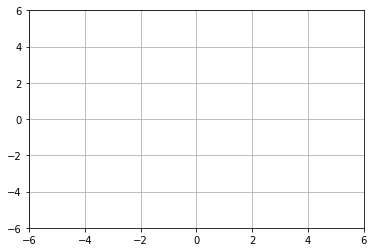

In [55]:
fig=plt.figure()
ax=fig.add_subplot(111,autoscale_on=False,xlim=(-6,6),ylim=(-6,6))
ax.grid()
line,=ax.plot([],[],'o-',lw=2)
linepath,=ax.plot([],[])
linepath1,=ax.plot([],[])
linepath2,=ax.plot([],[])
linepath3,=ax.plot([],[])

In [56]:
def init():
    line.set_data([],[])
    linepath.set_data([],[])
    linepath1.set_data([],[])
    linepath2.set_data([],[])
    linepath3.set_data([],[])
    
    return line,linepath,linepath1,linepath2

def animate(i):
    thisx=[0,position[i,0,0],position[i,1,0],position[i,2,0],position[i,3,0]] 
    thisy=[0,position[i,0,1],position[i,1,1],position[i,2,1],position[i,3,1]] 
    line.set_data(thisx,thisy)

    linepath.set_data(position[:i,3,0],position[:i,3,1])
    linepath1.set_data(position[:i,2,0],position[:i,2,1])
    linepath2.set_data(position[:i,1,0],position[:i,1,1])
    linepath3.set_data(position[:i,0,0],position[:i,0,1])
   

    return line,linepath,linepath1,linepath2
                    

In [57]:
length=position.shape[0]
ani=animation.FuncAnimation(fig,animate,np.arange(1,length),interval=30,blit=True,init_func=init)
ax.plot(env.goal[0],env.goal[1],marker='o',markersize=3,color='red')

plt.show()
ani.save("ik_by_rl.gif",writer='imagemagick',fps=50)

In [24]:
position[100,0,1]
#env.th

0.0

In [28]:
a=np.array([3,4,5,5,67,7])

In [19]:
a[:2]

NameError: name 'a' is not defined

In [35]:
range(1,5)

range(1, 5)

In [36]:
for i in range(1,5):
    print(i)

1
2
3
4
